In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import os
from transformers import BertModel, BertTokenizer, BertConfig
import pandas as pd
from torch.utils.data import DataLoader
import time
import warnings
from collections import defaultdict
import traceback
from tqdm import tqdm as tq
import argparse

# A. Data pre-processing

In [3]:
os.environ["PYTORCH_TRANSFORMERS_CACHE"] = "/scratch/user/sathvikkote/ml/.cache"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
file_path = 'yelp_review_train.csv'
yelp_data = pd.read_csv(file_path)

In [4]:
yelp_data.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


The dataset is highly unbalanced. There are lot of 5 star reviews compared to any other stars. This will affect the machine learning model.

<Axes: xlabel='stars'>

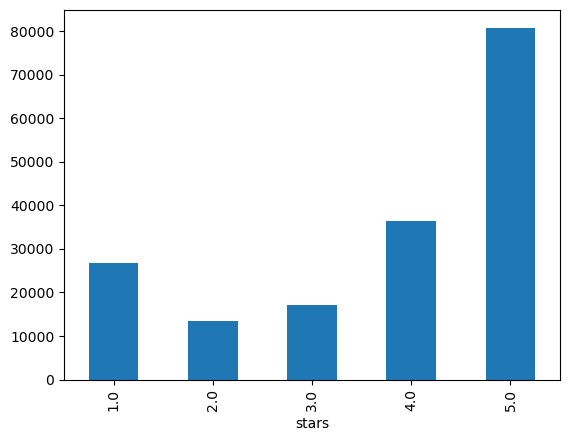

In [5]:
yelp_data['stars'].value_counts(dropna=False).sort_index().plot(kind='bar')

In [6]:
# To remove the stop words from the text, we will download the stopwords from nltk library
import nltk
from nltk.corpus import stopwords

custom_nltk_data_path = 'nltk/'

# Add the custom path to NLTK data path
nltk.data.path.append(custom_nltk_data_path)

# Check if 'stopwords' are downloaded, and if not, download them
if not os.path.isfile(os.path.join(custom_nltk_data_path, 'corpora/stopwords.zip')):
    nltk.download('stopwords', download_dir=custom_nltk_data_path)
    
stop_words = set(stopwords.words("english"))

In [7]:
import re

def clean_text(text, stop_words):
    # Remove non-alphanumeric characters (punctuation, special symbols, etc.)
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)

    # Convert the text to lowercase
    text = text.lower()

    # Split the text into a list of words
    text = text.split(" ")

    # Remove stop words from the list of words
    text = [word for word in text if not word in stop_words]

    text = " ".join(text)    
    return text


In [8]:
yelp_data['Processed_Reviews'] = yelp_data.text.apply(lambda x: clean_text(x, stop_words))

In [9]:
yelp_data.head()

,text,stars,Processed_Reviews
0,Went for lunch and found that my burger was me...,2.0,went lunch found burger meh obvious focus bur...
1,I needed a new tires for my wife's car. They h...,5.0,needed new tires wifes car special order next ...
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0,jim woltman works goleta honda 5 stars knowled...
3,Been here a few times to get some shrimp. The...,4.0,times get shrimp theyve got nice selection di...
4,This is one fantastic place to eat whether you...,5.0,one fantastic place eat whether hungry need go...


Now we will categorize the into positive, neutral and negative

In [10]:
def categorize_stars(stars):
    if stars > 3:
        return 'POSITIVE'
    elif stars <= 2:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

In [11]:
yelp_data['label'] = yelp_data['stars'].apply(categorize_stars)

category_one_hot = pd.get_dummies(yelp_data['label'])

# Concatenate the one-hot encoded columns with the original DataFrame
yelp_data = pd.concat([yelp_data, category_one_hot], axis=1)

In [12]:
yelp_data.head()

,text,stars,Processed_Reviews,label,NEGATIVE,NEUTRAL,POSITIVE
0,Went for lunch and found that my burger was me...,2.0,went lunch found burger meh obvious focus bur...,NEGATIVE,True,False,False
1,I needed a new tires for my wife's car. They h...,5.0,needed new tires wifes car special order next ...,POSITIVE,False,False,True
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0,jim woltman works goleta honda 5 stars knowled...,POSITIVE,False,False,True
3,Been here a few times to get some shrimp. The...,4.0,times get shrimp theyve got nice selection di...,POSITIVE,False,False,True
4,This is one fantastic place to eat whether you...,5.0,one fantastic place eat whether hungry need go...,POSITIVE,False,False,True


<Axes: xlabel='label'>

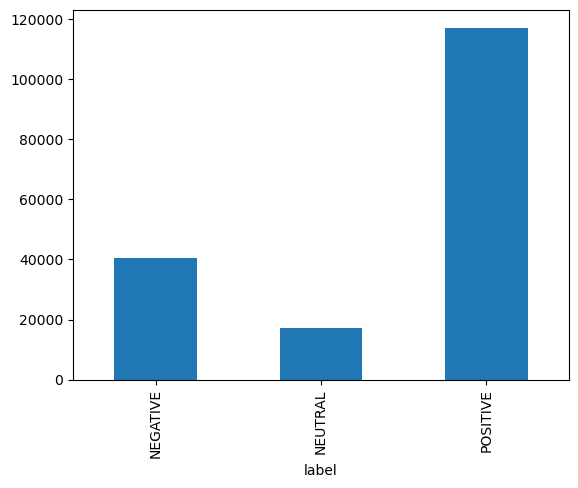

In [13]:
yelp_data['label'].value_counts(dropna=False).sort_index().plot(kind='bar')

If you look at the graph after assigning a label, the data is extremely unbalanced. For us to have a better model, we need to have a balanced data set. There are multiple ways to balance the data like data augmentation, Synthetic Sampling, over sampling, under sampling, etc. For our case, we will do under sampling. And that data is further used to run all the experiments.

In [14]:
positive_data = yelp_data[yelp_data['label'] == 'POSITIVE'].sample(n=20000, replace=True)
negative_data = yelp_data[yelp_data['label'] == 'NEGATIVE'].sample(n=20000, replace=True)
neutral_data = yelp_data[yelp_data['label'] == 'NEUTRAL']

# Concatenate the balanced subsets
yelp_data = pd.concat([positive_data, negative_data, neutral_data])

Below is the balanced dataset

<Axes: xlabel='label'>

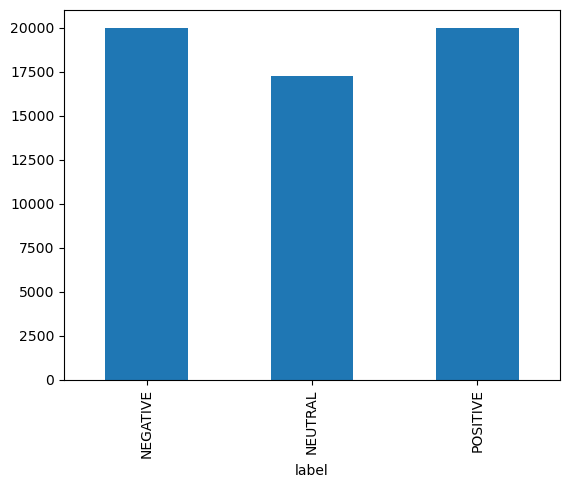

In [15]:
yelp_data['label'].value_counts(dropna=False).sort_index().plot(kind='bar')

All the preprocessing with the train and test split can be done in the below method.

In [16]:
def preprocessData(yelp_data, test_size = 0.1, balance = False):
    custom_nltk_data_path = 'nltk/'

    # Add the custom path to NLTK data path
    nltk.data.path.append(custom_nltk_data_path)

    # Check if 'stopwords' are downloaded, and if not, download them
    if not os.path.isfile(os.path.join(custom_nltk_data_path, 'corpora/stopwords.zip')):
        nltk.download('stopwords', download_dir=custom_nltk_data_path)

    # Check if 'wordnet' is downloaded, and if not, download it
    if not os.path.isfile(os.path.join(custom_nltk_data_path, 'corpora/wordnet.zip')):
        nltk.download('wordnet', download_dir=custom_nltk_data_path)
    stop_words = set(stopwords.words("english"))

    yelp_data['Processed_Reviews'] = yelp_data.text.apply(lambda x: clean_text(x, stop_words))

    # Apply star categorization to 'stars' column
    yelp_data['label'] = yelp_data['stars'].apply(categorize_stars)

    category_one_hot = pd.get_dummies(yelp_data['label'])

	# Concatenate the one-hot encoded columns with the original DataFrame
    yelp_data = pd.concat([yelp_data, category_one_hot], axis=1)

    if balance:
        positive_data = yelp_data[yelp_data['label'] == 'POSITIVE'].sample(n=20000, replace=True)
        negative_data = yelp_data[yelp_data['label'] == 'NEGATIVE'].sample(n=20000, replace=True)
        neutral_data = yelp_data[yelp_data['label'] == 'NEUTRAL']

        # Concatenate the balanced subsets
        yelp_data = pd.concat([positive_data, negative_data, neutral_data])

    if test_size == 0:
        return yelp_data['text'].values, None, yelp_data[['POSITIVE', 'NEUTRAL', 'NEGATIVE']].values, None

	# Split dataset into train and validation sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
	    yelp_data['text'].values,
	    yelp_data[['POSITIVE', 'NEUTRAL', 'NEGATIVE']].values,
	    test_size=test_size,
	    random_state=42
	)

    return train_texts, val_texts, train_labels, val_labels

# B. Input data preparation

In [17]:
from torch.utils.data import Dataset

class YelpDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
        - texts: List of text reviews.
        - labels: List of corresponding labels.
        - tokenizer: Tokenizer object, usually from a Transformer-based model.
        - max_length: Maximum length for the input sequence.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Returns the length of the dataset (number of reviews).
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset based on the index idx.
        Tokenizes the text and prepares the input data for the Transformer model.
        """
        text = str(self.texts[idx])  # Get text review
        label = self.labels[idx]  # Get corresponding label

        # Tokenize the text using tokenizer.encode_plus()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_tensors='pt',
            padding='max_length',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),  # Flattened input tensor containing token IDs
            'attention_mask': encoding['attention_mask'].flatten(),  # Flattened attention mask tensor
            'label': torch.tensor(label, dtype=torch.float)  # Convert label to torch.float and include it
        }


In [18]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    yelp_data['text'].values,
    yelp_data[['POSITIVE', 'NEUTRAL', 'NEGATIVE']].values,
    test_size=0.1,
    random_state=42
)

In [19]:
# Create instances of custom datasets for training and validation

#Based on the experiments performed, we will fix MAX_LENGTH as 256
MAX_LENGTH = 256
train_dataset = YelpDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = YelpDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)

In [20]:
# Create data loaders

#Based on the experiments performed, we will fix BATCH_SIZE as 8
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# C. Transformer Implementation

For our experiments we will use two types of classifiers. 
1. Without hidden layer
2. With hidden layer

The dimensionality reduction from 768 to 3 can have some effect on the performance of the model. Hence, trying both the varitaions can help to build the right model

In [21]:
class FNN1LayerClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FNN1LayerClassifier, self).__init__()
        # Dropout layer with a dropout rate of 0.1 for regularization
        self.dropout1 = nn.Dropout(0.1)
        # Linear layer mapping BERT output size (768) to the number of classes
        self.linear = nn.Linear(768, num_classes)
        # Softmax activation function to generate class probabilities
        self.act1 = nn.Softmax()

    def forward(self, input):
        # Apply dropout to the input tensor
        x = self.dropout1(input)
        # Pass the input through the linear layer and apply softmax activation
        x = self.act1(self.linear(x))
        # Return the output tensor containing class probabilities
        return x

In [22]:
class FNN2LayerClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FNN2LayerClassifier, self).__init__()
        # Dropout layer with a dropout rate of 0.1 for regularization
        self.dropout1 = nn.Dropout(0.1)
        # Linear layer mapping BERT output size (768) to a hidden layer size (128)
        self.linear = nn.Linear(768, 128)
        # ReLU activation function for introducing non-linearity
        self.act1 = nn.ReLU()
        # Layer normalization for stabilizing learning in deep networks
        self.batch_norm = nn.LayerNorm(128)
        # Another dropout layer
        self.dropout2 = nn.Dropout(0.1)
        # Output layer mapping hidden layer size (128) to the number of classes
        self.out = nn.Linear(128, num_classes)
        # Softmax activation function to generate class probabilities
        self.act2 = nn.Softmax()
    
    def forward(self, input):
        # Apply dropout to the input tensor
        x = self.dropout1(input)
        # Pass the input through the linear layer and apply ReLU activation
        x = self.act1(self.linear(x))
        # Apply layer normalization
        x = self.batch_norm(x)
        # Apply another dropout
        x = self.dropout2(x)
        # Pass through the output layer and apply softmax activation
        x = self.act2(self.out(x))
        # Return the output tensor containing class probabilities
        return x

Below are the transformer models, which uses pretrained bert-base model [with positional embedding , multi-head self attention], that are used to fit the dataset.
1. One transformer works on the pooled output of the bert base model
2. Second transformer uses [CLS] taken of the specified layer 

In [23]:
class BaseBertClassifier(nn.Module):
    def __init__(self, bert_model, linear_fnn, freeze = True):
        super(BaseBertClassifier, self).__init__()
        self.bert = bert_model
        self.fnn = linear_fnn

        # Freeze BERT layers
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

        # Unfreeze the feedforward neural network layers for training
        for param in self.fnn.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Use pooler_output from BERT
        x = self.fnn(pooled_output)
        return x

In [24]:
class BaseBertLayerwiseClassifier(nn.Module):
    def __init__(self, bert_model, linear_fnn, layer = None, freeze = True):
        super(BaseBertLayerwiseClassifier, self).__init__()
        self.bert = bert_model
        self.fnn = linear_fnn
        self.layer = layer

        # Freeze BERT layers
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

        # Unfreeze the feedforward neural network layers for training
        for param in self.fnn.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        if self.layer is None:
            pooled_output = outputs.pooler_output  # Use pooler_output from BERT
            x = self.fnn(pooled_output)
            return x
        else:
            hidden_states = outputs[2]  # Get all hidden states (layers)

            # Select the output of the 12th layer (index 12, as index 0 represents the input embeddings)
            bert_output_ith_layer = hidden_states[self.layer]  # Output of the 12th layer

            # Extract the [CLS] token embedding (index 0) for classification
            cls_token_embeddings = bert_output_ith_layer[:, 0, :]  # Select the [CLS] token embedding

            # Pass the [CLS] token embedding through the feedforward neural network
            x = self.fnn(cls_token_embeddings)
            return x

# D. Model Training

The trianing of the models are performed on the hrpc resource. Four approachs or steps are performed to obtain the final model.
The steps are:
1. Designing the classifier: To check single layer(FNN1LayerClassifier) or double layer (FNN2LayerClassifier) performs well for classification.
2. Fine tuning the parameters: [MAX_LENGTH, LEARNING_RATE, BATCH_SIZE]
3. Finding the right context: To find the right output for the classification tasks [Pooled output or output from one of the hidden layers]
4. Unfreeze the bert model: Train the parameters of the bert model specifically for classification.

The results of the each approach can be found here [https://github.com/sathvikkote/Text-Classification-Using-Base-Bert/tree/main/results/train]

Below are few code blocks, that are used to train the model.

In [25]:
# Utils to save results and plot

def saveResults(filename, content):
    file_path  = 'results/train/' + filename;
    with open(file_path, 'w') as file:
        file.write(content)
        file.close()

def plotGraph(x_values, y_values, title, x_label, y_label, y_markings, path):
    plt.figure(figsize=(8, 5))
    for y_val, label in zip(y_values, y_markings):
        plt.plot(x_values, y_val, label=label, marker='o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    # Save the plot as an image (e.g., PNG, JPG, PDF, etc.)
    plt.savefig(path + title + '.png')  # Change the file format as needed (e.g., .png, .jpg, .pdf)

In [26]:
# Class to hold logs
class Log:
    def __init__(self):
        self.log_string = ""

    def log(self, message):
        print(message)
        self.log_string += message + "\n"

    def getLog(self):
        return self.log_string

In [27]:
# Class to track metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize

class MetricsTracker:
    def __init__(self, auc = False):
        self.initialize()
        self.auc = auc
    
    def initialize(self):
        self.accuracy = 0
        self.loss = 0
        self.f1_macro = 0
        self.f1_weighted = 0
        self.class_total = defaultdict(int)
        self.class_correct = defaultdict(int)
        self.predicted_labels = []
        self.predicted_proba= []
        self.true_labels = []
        self.totals = 0
        self.corrects = 0
    
    def getF1Scores(self):
        return self.f1_macro, self.f1_weighted
    
    def getAUC(self):
        if not self.auc:
            return [], []
        auc_value_macro, auc_value_weighted = {}, {}
        y_true = np.array(self.true_labels)
        y_pred = np.array(self.predicted_proba)

        for i in range(3):
            auc = roc_auc_score(y_true[:, i], y_pred[:, i], average='macro')
            auc_value_macro[i] = auc
            auc = roc_auc_score(y_true[:, i], y_pred[:, i], average='weighted')
            auc_value_weighted[i] = auc
        return auc_value_macro, auc_value_weighted
    
    def getLoss(self):
        return self.loss, self.loss / self.totals
    
    def getCounts(self):
        return self.totals, self.corrects

    def getClassCounts(self):
        return self.class_total, self.class_correct
    
    def getAccurary(self):
        class_accuracy = {}
        for label, correct_count in self.class_correct.items():
            total_count = self.class_total[label]
            accuracy = correct_count / total_count if total_count > 0 else 0.0
            class_accuracy[label] = accuracy * 100
        return self.accuracy, class_accuracy
    
    def addBatchResults(self, outputs, labels, loss):
        self.loss += loss.item()

        label_arg = torch.argmax(labels, dim = 1)
        predicted = torch.argmax(outputs, dim = 1)

        for x in outputs:
            one_hot = np.zeros(len(x), dtype=int)
            one_hot[torch.argmax(x)] = 1
            self.predicted_labels.append(one_hot)
            if self.auc:
                self.predicted_proba += [x.cpu().numpy()]

        for x in labels:
            cpu = x.cpu().numpy()
            self.true_labels += [cpu]
        
        for i in range(len(label_arg)):
            label = label_arg[i].item()
            pred = predicted[i].item()
            
            # Increment counts for the corresponding class
            self.class_total[label] += 1
            self.class_correct[label] += int(pred == label)

        self.totals += labels.size(0)
        self.corrects += (predicted == label_arg).sum().item()
        self.accuracy = (100 * self.corrects) / self.totals
        self.f1_macro = f1_score(self.true_labels, self.predicted_labels, average='macro')
        self.f1_weighted = f1_score(self.true_labels, self.predicted_labels, average='weighted')
    
    def plot_confusion_matrix(self, path, show = False):
        # Calculate confusion matrix
        y_true = np.array(self.true_labels)
        y_pred = np.array(self.predicted_labels)
        cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

        # Plot confusion matrix with numbers
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Class 0', 'Class 1', 'Class 2'],  # Update labels as needed
                    yticklabels=['Class 0', 'Class 1', 'Class 2'],  # Update labels as needed
                    )
        for i in range(len(cm)):
            for j in range(len(cm)):
                plt.text(j + 0.5, i + 0.5, str(cm[i][j]), ha='center', va='center', color='red')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig(path + '_ConfusionMetrics.png')
        if show:
            plt.show()


    def plotROCCurve(self, path, show = False):
        if not self.auc:
            print("AUC metric is not enabled.")
            return

        y_true = label_binarize(self.true_labels, classes=[0, 1, 2])  # Update classes based on your task
        y_score = np.array(self.predicted_proba)

        n_classes = y_true.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for each class')
        plt.legend(loc="lower right")
        plt.savefig(path + '_ROCCurve.png')
        if show:
            plt.show()

In [28]:
import numpy as np
import time
from collections import defaultdict
from sklearn.metrics import f1_score
from tqdm import tqdm as tq

# Engine that will train the model
class Trainer:
    def __init__(self, model, name, learning_rate=0.001, criterion=None, optimizer=None, device='cpu'):
        # Initialize the Trainer with necessary parameters
        self.model = model
        self.criterion = criterion
        self.device = device
        self.model.to(self.device)
        self.name = name
        self.logger = Log()  # Initialize logging object
        self.learning_rate = learning_rate
        self.list_of_training_accuracy = []  # List to store training accuracy over epochs
        self.list_of_validation_accuracy = []  # List to store validation accuracy over epochs
        # Lists to store training and validation loss over epochs
        self.list_of_training_loss = []
        self.list_of_validation_loss = []
        # Lists to store training and validation F1 score over epochs
        self.list_of_training_f1 = []
        self.list_of_validation_f1 = []
        # Set optimizer if not provided
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08) if optimizer is None else optimizer
        # Set criterion (loss function) if not provided
        if criterion is None:
            self.criterion = nn.CrossEntropyLoss()
            
    def trainBatch(self, input_ids, attention_mask, labels, metrics):
        # Perform a single training step on a batch
        self.optimizer.zero_grad()
        outputs = self.model(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        metrics.addBatchResults(outputs, labels, loss)

    def train(self, train_loader, val_loader=None, num_epochs=5, save = False):
        filename  = self.name +'_' +str(self.learning_rate) +'_'+ str(num_epochs)

        self.logger.log('-------------------------------------------')
        self.logger.log(f'Training model {self.name} . Learning Parameter {self.learning_rate}. num_of_epochs {num_epochs}')

        train_start_time = time.time()
        
        for epoch in range(num_epochs):

            metrics = MetricsTracker()
            self.logger.log(f'Epoch {epoch + 1}/{num_epochs}:')
            epoch_start_time = time.time()
            self.model.train()  # Set model to training mode

            with tq(train_loader,unit="batch") as td:
                for batch in td:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['label'].to(self.device)
                    
                    self.trainBatch(input_ids, attention_mask, labels, metrics)

                    accuracy , _ = metrics.getAccurary()
                    _, weighted_f1 = metrics.getF1Scores()
                    td.set_description(desc = f"Accuracy={accuracy:.4f} f1:{weighted_f1:.4f}")
        

            train_accuracy, class_accuracy = metrics.getAccurary()
            f1_macro, f1_weighted = metrics.getF1Scores()
            train_loss , avg_train_loss = metrics.getLoss()
            train_total, train_correct = metrics.getCounts()

            self.list_of_training_accuracy.append(train_accuracy)
            self.list_of_training_loss.append(train_loss)
            self.list_of_training_f1.append(f1_weighted)

            self.logger.log(f'Training F1 score Weighted: {f1_weighted:.4f} Macro: {f1_macro:.4f}')
            self.logger.log(f'Training Avg Loss: {avg_train_loss:.4f}, Total Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Train Correct: {train_correct}, Train Total: {train_total}')

            # Validation step (if validation loader is provided)
            if val_loader is not None:
                self.validate(val_loader)

            epoch_end_time = time.time()
            
            epoch_time = epoch_end_time - epoch_start_time            
            self.logger.log(f"Epoch took: {epoch_time:.2f} seconds")

        train_end_time = time.time()
        # Calculate the elapsed time for the epoch
        train_time = train_end_time - train_start_time
        self.logger.log(f"Training took: {train_time:.2f} seconds")
        self.logger.log('-------------------------------------------')

        utils.saveResults(filename, self.logger.getLog())
        utils.plotGraph(np.arange(1, num_epochs + 1), [self.list_of_training_accuracy, self.list_of_validation_accuracy], 'Training and Validation Accuracy',
                        'Epoch', 'Accuracy', ['Training Accuracy', 'Validation Accuracy'], 'results/train/graphs/'+ filename)
        utils.plotGraph(np.arange(1, num_epochs + 1), [self.list_of_training_loss, self.list_of_validation_loss], 'Training and Validation Loss',
                        'Epoch', 'Loss', ['Training Loss', 'Validation Loss'], 'results/train/graphs/'+ filename)
        utils.plotGraph(np.arange(1, num_epochs + 1), [self.list_of_training_f1, self.list_of_validation_f1], 'Training and Validation F1',
                        'Epoch', 'F1', ['Training F1', 'Validation F1'], 'results/train/graphs/'+ filename)

        if save:
            torch.save(self.model.state_dict(), 'models/pytorch/' + filename + '.pth')

    def eval(self, test_loader, save_results = True):
        test_start_time = time.time()
        self.logger.log('-------------------------------------------')

        self.validate(test_loader, testing = True)

        test_end_time = time.time()
        self.logger.log('-------------------------------------------')


    def validate(self, val_loader, testing = False):
        self.model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_total = 0
        val_correct = 0
        class_correct = defaultdict(int)
        class_total = defaultdict(int)

        true_labels = []
        predicted_labels = []
        f1  = 0

        metrics = MetricsTracker(auc=testing)

        with torch.no_grad():
            with tq(val_loader,unit="batch") as td:
                for batch in td:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['label'].to(self.device)

                    outputs = self.model(input_ids, attention_mask)
                    loss = self.criterion(labels, outputs)
                    metrics.addBatchResults(outputs, labels, loss)

                    val_accuracy, _ = metrics.getAccurary()
                    _, weighted_f1  = metrics.getF1Scores()

                    td.set_description(desc = f"Accuracy={val_accuracy:.4f} f1: {weighted_f1:.4f}")

        f1_macro, f1_weighted = metrics.getF1Scores()
        accuracy, class_acc = metrics.getAccurary()
        loss, avg_loss = metrics.getLoss()
        val_total, val_correct = metrics.getCounts()

        self.list_of_validation_accuracy.append(accuracy)
        self.list_of_validation_loss.append(loss)
        self.list_of_validation_f1.append(f1_weighted)

        self.logger.log(f'Validation Loss: {avg_loss:.4f}, Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}, val correct: {val_correct}, Val Total: {val_total}')
        self.logger.log(f'The F1 score : Weighted {f1_weighted:.4f} Macro {f1_macro:.4f}')

        class_total, class_correct = metrics.getClassCounts()
        self.logger.log("Per-class accuracy:")
        for label, accuracy in class_acc.items():
            self.logger.log(f"Class {label}: {accuracy:.2f}% ({class_correct[label]}/{class_total[label]})")
            
        if testing:
            auc_value_macro, auc_value_weighted = metrics.getAUC()
            self.logger.log(f'The AUC Score : Weighted {auc_value_weighted} Macro {auc_value_macro}')
            path = 'results/test/graphs/' + self.name 
            metrics.plotROCCurve(path, testing)
            metrics.plot_confusion_matrix(path, testing)    

In [29]:
# Preparing data for training and validation
def prepData():
    # Set the environment variable for the cache directory
    os.environ["PYTORCH_TRANSFORMERS_CACHE"] = "/scratch/user/sathvikkote/ml/.cache"

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    file_path = 'yelp_review_train.csv'
    yelp_data = pd.read_csv(file_path)

    train_texts, val_texts, train_labels, val_labels = preprocessor.preprocessData(yelp_data, balance= True)

    # Create instances of custom datasets for training and validation
    train_dataset = YelpDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
    val_dataset = YelpDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)


    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    return train_loader, val_loader

In [30]:
def buildAndTrain(name, model, train_loader, val_loader, device, lr, num_epochs, save):
    try:
        trainer = Trainer(model, name=name, learning_rate = lr, device = device)
        trainer.train(train_loader, val_loader, num_epochs = num_epochs, save = save)

    except Exception as e:
        error_message = f"An error occurred: {str(e)}"
        traceback.print_exc()
        print(error_message)
        file_path = "error_log.txt"

        with open(file_path, 'a') as file:
            file.write(error_message + "\n")
            file.close()

### Step 1: Classifier Design

In [31]:
def classifierDesign(saveModel = False):
    print(f'Save Model : {saveModel}')
    print('Device: ',torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    train_loader, val_loader = prepData()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    pretrained_bert = BertModel.from_pretrained('bert-base-uncased')
    name = 'baseBertWith2LayerClassfier'
    baseBertWith2layerClassifier = BaseBertLayerwiseClassifier(pretrained_bert, FNN2LayerClassifier(3))
    buildAndTrain( name, baseBertWith2layerClassifier, train_loader, val_loader, device, 2e-05, 8, saveModel)

    pretrained_bert = BertModel.from_pretrained('bert-base-uncased')
    name = 'baseBertWith1LayerClassfier'
    baseBertWith1LayerClassfier = BaseBertLayerwiseClassifier(pretrained_bert, FNN1LayerClassifier(3))
    buildAndTrain(name, baseBertWith1LayerClassfier, train_loader, val_loader, device, 2e-05, 8, saveModel)

### Step 2: Parameter Tuning

In [32]:
def parameterTuning(saveModel = False):
    print(f'Save Model : {saveModel}')
    print('Device: ',torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for length in [512, 256]:
        for batch in [16 , 8]:
            BATCH_SIZE = batch
            MAX_LENGTH = length

            train_loader, val_loader = prepData()
            pretrained_bert = BertModel.from_pretrained('bert-base-uncased')
            name = 'baseBertWith2LayerClassfier_' + str(length) + '_' + str(batch)
            baseBertWith2layerClassifier = BaseBertLayerwiseClassifier(pretrained_bert, FNN2LayerClassifier(3))
            buildAndTrain( name, baseBertWith2layerClassifier, train_loader, val_loader, device, 2e-05, 8, saveModel)


### Step 3: Layer Selection

In [33]:
def layerSelection(saveModel = False):
    print(f'Save Model : {saveModel}')
    print('Device: ',torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    train_loader, val_loader = prepData()
    
    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for layer in range(0,13):
        pretrained_bert = BertModel.from_pretrained('bert-base-uncased',  output_hidden_states=True)
        bertwith2fnn = BaseBertLayerwiseClassifier(pretrained_bert,  FNN2LayerClassifier(3), layer)
        name = 'bert_with_2_fnn_' + str(layer) + '_layer'
        buildAndTrain(name, bertwith2fnn, train_loader, val_loader, device, 2e-05, 3, saveModel)

### Step 4: Unfreeze the Bert

In [34]:
def freezingUnfreezingTraining(saveModel = False):
    print('Save Model ',saveModel)
    print('Device: ',torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    train_loader, val_loader = prepData()

    pretrained_bert = BertModel.from_pretrained('bert-base-uncased',  output_hidden_states=True)
    name = 'baseBertWith2LayerClassfierUsing12Layer'
    baseBertWith2LayerClassfierUsing12Layer = BaseBertLayerwiseClassifier(pretrained_bert, FNN2LayerClassifier(3), layer = 12)
    buildAndTrain(name, baseBertWith2LayerClassfierUsing12Layer, train_loader, val_loader, device, 2e-05, 4, saveModel)

    pretrained_bert = BertModel.from_pretrained('bert-base-uncased',  output_hidden_states=True)
    name = 'baseBertWith2LayerClassfierUsing12LayerUnFreeze'
    baseBertWith2LayerClassfierUsing12LayerUnFreeze = BaseBertLayerwiseClassifier(pretrained_bert,  FNN2LayerClassifier(3), 12, freeze = False)
    baseBertWith2LayerClassfierUsing12LayerUnFreeze.load_state_dict(torch.load('models/pytorch/baseBertWith2LayerClassfierUsing12Layer_2e-05_4.pth'))
    buildAndTrain(name, baseBertWith2LayerClassfierUsing12LayerUnFreeze, train_loader, val_loader, device, 2e-05, 4, saveModel)


# E. Result Analysis

In [35]:
# Utils to Evaluate teh models:
def evaluate(path, classifier_layers, name, layer):
    if path is None:
        return
    if classifier_layers is None:
        return
    if name is None:
        return
    print('Started Evaluating')
    print(f'Path: {path} Name: {name} Classifier : {classifier_layers} layer : {layer}')

    if int(classifier_layers) == 1:
        classifier = FNN1LayerClassifier(3)
    else:
        classifier =  FNN2LayerClassifier(3)

    pretrained_bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
    if layer:
        model = BaseBertLayerwiseClassifier(pretrained_bert, classifier, layer = int(layer[0]))
    else:
        model = BaseBertClassifier(pretrained_bert, classifier)
        
    model.load_state_dict(torch.load(path))

    file_path = 'yelp_review_test.csv'
    yelp_data = pd.read_csv(file_path)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    train_texts, val_texts, train_labels, val_labels = preprocessData(yelp_data, test_size = 0.0)

    # Create instances of custom datasets for training and validation
    test_dataset = YelpDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)

    # Create data loaders
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    trainer = Trainer(model, name = name,device = device)
    trainer.eval(test_loader)
    print('Finished Evaluation')

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 1. Evaluate Classifer Design

Started Evaluating
Path: /scratch/user/sathvikkote/models/ClassifierDesign/pytorch/baseBertWith1LayerClassfier_2e-05_8.pth Name: ClassifierLayer1 Classifier : 1 layer : []
-------------------------------------------


Accuracy=73.7482 f1: 0.7553: 100%|██████████████████████████████████████████████████████| 219/219 [01:37<00:00,  2.25batch/s]


Validation Loss: 0.0151, Validation Loss: 210.5444, Validation Accuracy: 73.7482, val correct: 10310, Val Total: 13980
The F1 score : Weighted 0.7553 Macro 0.6229
Per-class accuracy:
Class 1: 43.08% (610/1416)
Class 2: 76.82% (2416/3145)
Class 0: 77.33% (7284/9419)
The AUC Score : Weighted {0: 0.893277136793504, 1: 0.7650728271251194, 2: 0.9099014777963719} Macro {0: 0.893277136793504, 1: 0.7650728271251194, 2: 0.9099014777963719}


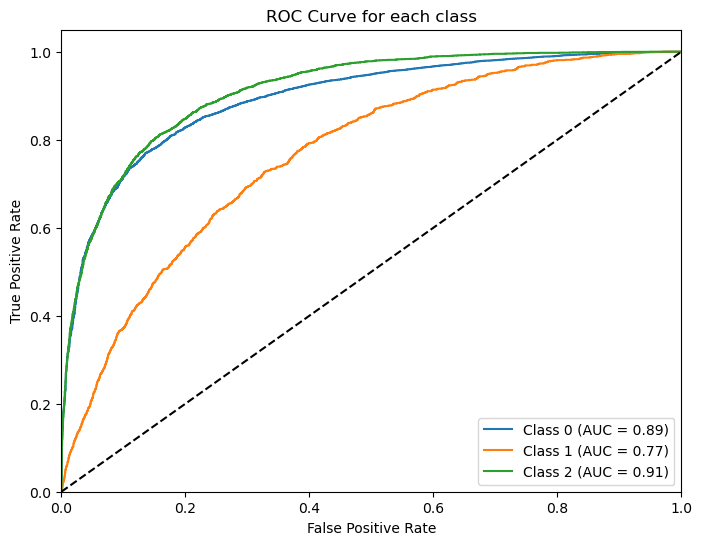

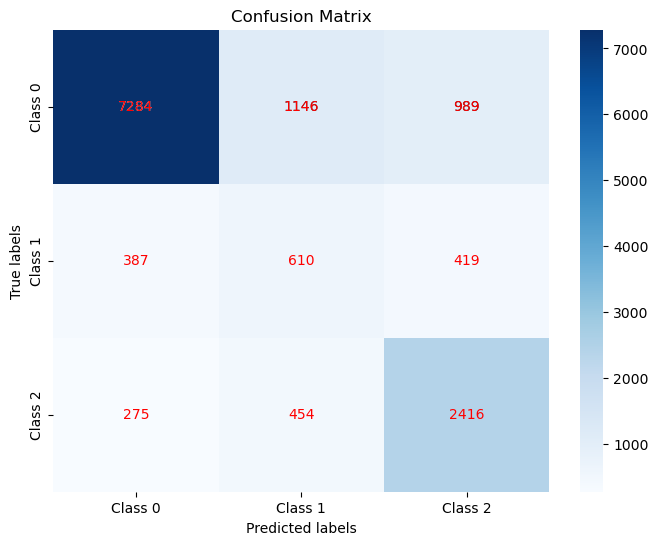

-------------------------------------------
Finished Evaluation


In [37]:
# Classifier with 1 layer
evaluate('/scratch/user/sathvikkote/models/ClassifierDesign/pytorch/baseBertWith1LayerClassfier_2e-05_8.pth', '1', 'ClassifierLayer1', [])

Started Evaluating
Path: /scratch/user/sathvikkote/models/ClassifierDesign/pytorch/baseBertWith2LayerClassfier_2e-05_8.pth Name: ClassifierLayer2 Classifier : 2 layer : []
-------------------------------------------


Accuracy=80.2432 f1: 0.8153: 100%|██████████████████████████████████████████████████████| 219/219 [01:36<00:00,  2.26batch/s]


Validation Loss: 0.0119, Validation Loss: 166.1319, Validation Accuracy: 80.2432, val correct: 11218, Val Total: 13980
The F1 score : Weighted 0.8153 Macro 0.6879
Per-class accuracy:
Class 0: 85.69% (8071/9419)
Class 2: 77.71% (2444/3145)
Class 1: 49.65% (703/1416)
The AUC Score : Weighted {0: 0.9351758222678419, 1: 0.8243225757567583, 2: 0.9542260075434157} Macro {0: 0.9351758222678419, 1: 0.8243225757567583, 2: 0.9542260075434157}


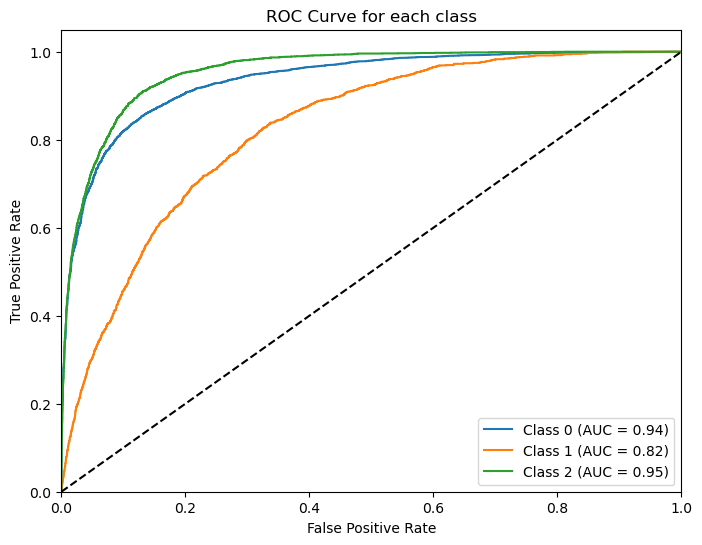

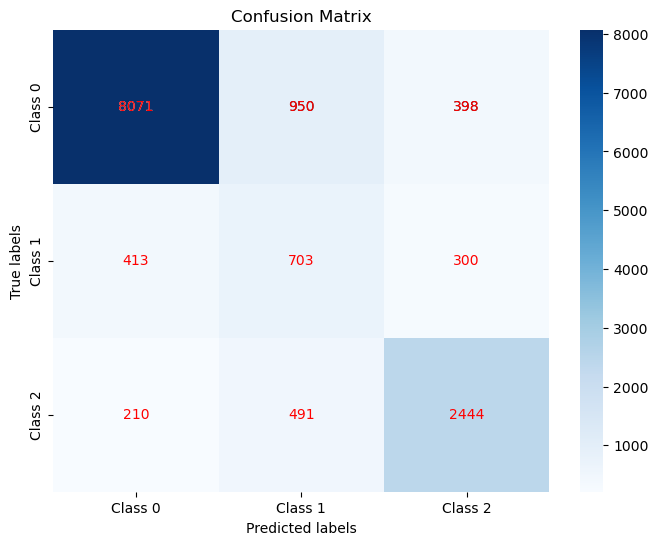

-------------------------------------------
Finished Evaluation


In [38]:
# Classifier with 2 layer
evaluate('/scratch/user/sathvikkote/models/ClassifierDesign/pytorch/baseBertWith2LayerClassfier_2e-05_8.pth', '2', 'ClassifierLayer2', [])

### 2. Evaluate Parameter Tuning

Started Evaluating
Path: /scratch/user/sathvikkote/models/parameterTuning/pytorch/baseBertWith2LayerClassfier_256_8_2e-05_4.pth Name: PT256_8 Classifier : 2 layer : []
-------------------------------------------


Accuracy=76.5522 f1: 0.7930: 100%|██████████████████████████████████████████████████████| 219/219 [01:38<00:00,  2.23batch/s]


Validation Loss: 0.0126, Validation Loss: 175.9177, Validation Accuracy: 76.5522, val correct: 10702, Val Total: 13980
The F1 score : Weighted 0.7930 Macro 0.6709
Per-class accuracy:
Class 1: 62.01% (878/1416)
Class 2: 72.97% (2295/3145)
Class 0: 79.93% (7529/9419)
The AUC Score : Weighted {0: 0.9287367133271394, 1: 0.8149169472639071, 2: 0.9491581556854773} Macro {0: 0.9287367133271394, 1: 0.8149169472639071, 2: 0.9491581556854773}


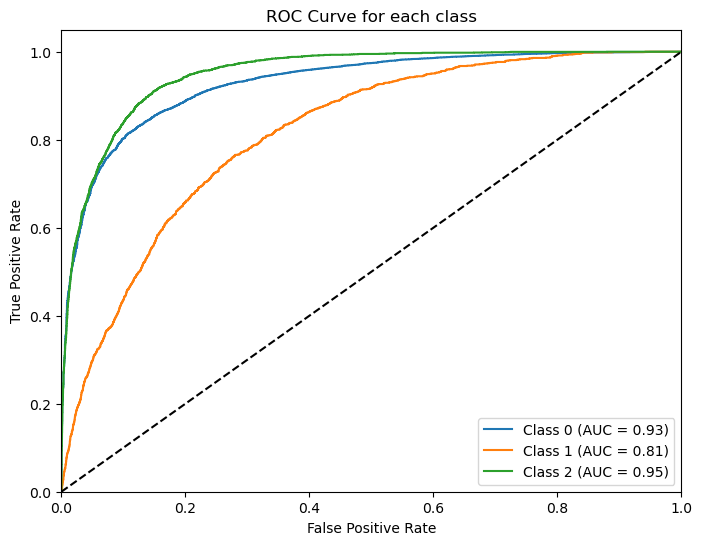

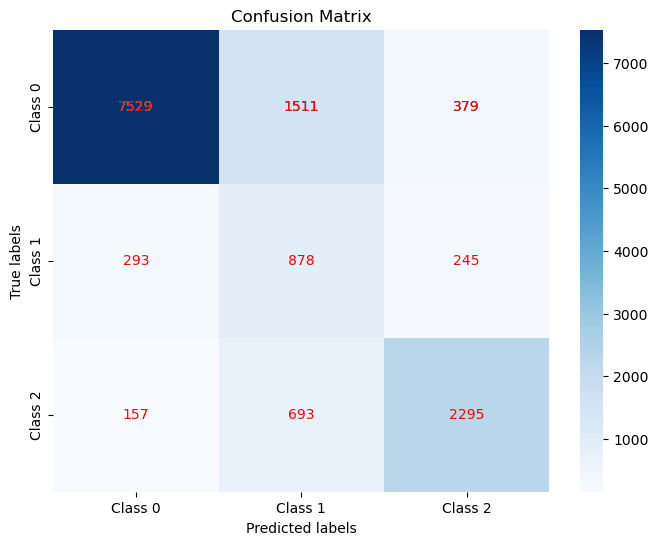

-------------------------------------------
Finished Evaluation


In [39]:
# MAX_LENGTH = 256 and BATCH_SIZE = 8 LR = 2e-05
evaluate('/scratch/user/sathvikkote/models/parameterTuning/pytorch/baseBertWith2LayerClassfier_256_8_2e-05_4.pth', '2', 'PT256_8', [])

Started Evaluating
Path: /scratch/user/sathvikkote/models/parameterTuning/pytorch/baseBertWith2LayerClassfier_256_16_2e-05_4.pth Name: PT256_16 Classifier : 2 layer : []
-------------------------------------------


Accuracy=78.3548 f1: 0.7991: 100%|██████████████████████████████████████████████████████| 219/219 [01:35<00:00,  2.29batch/s]


Validation Loss: 0.0123, Validation Loss: 171.9701, Validation Accuracy: 78.3548, val correct: 10954, Val Total: 13980
The F1 score : Weighted 0.7991 Macro 0.6708
Per-class accuracy:
Class 1: 48.31% (684/1416)
Class 0: 82.68% (7788/9419)
Class 2: 78.92% (2482/3145)
The AUC Score : Weighted {0: 0.9258310376156607, 1: 0.8080769679579536, 2: 0.9472009760513792} Macro {0: 0.9258310376156607, 1: 0.8080769679579536, 2: 0.9472009760513792}


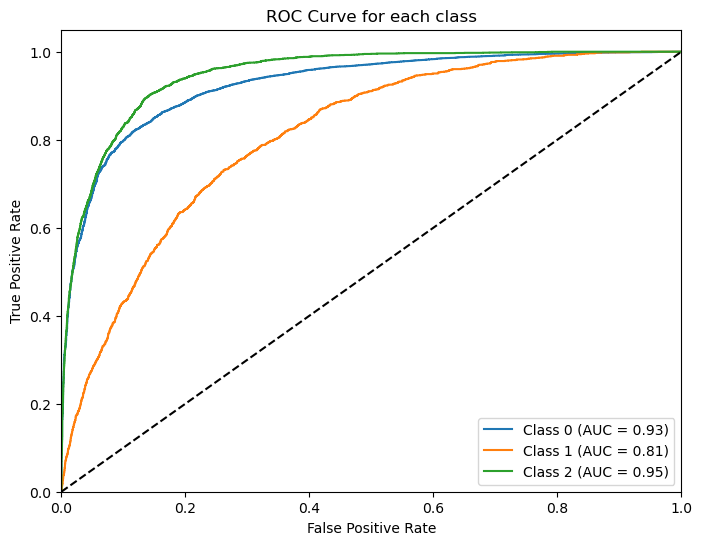

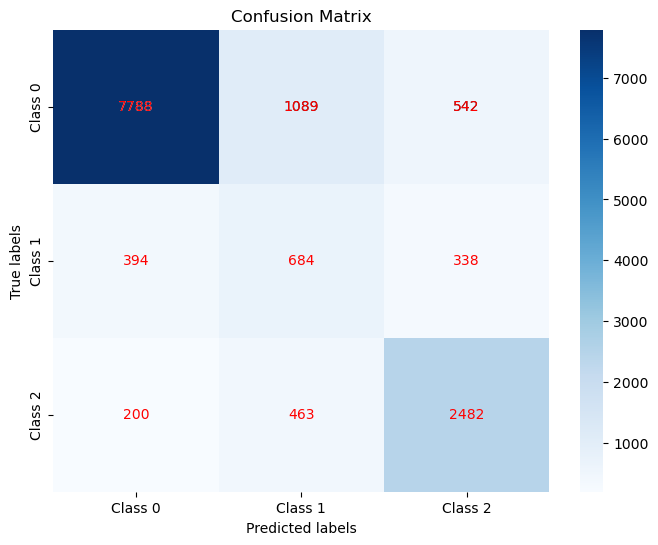

-------------------------------------------
Finished Evaluation


In [40]:
# MAX_LENGTH = 256 and BATCH_SIZE = 16 LR = 2e-05
evaluate('/scratch/user/sathvikkote/models/parameterTuning/pytorch/baseBertWith2LayerClassfier_256_16_2e-05_4.pth', '2', 'PT256_16', [])

Started Evaluating
Path: /scratch/user/sathvikkote/models/parameterTuning/pytorch/baseBertWith2LayerClassfier_512_8_2e-05_4.pth Name: PT256_16 Classifier : 2 layer : []
-------------------------------------------


Accuracy=79.9857 f1: 0.8118: 100%|██████████████████████████████████████████████████████| 219/219 [01:37<00:00,  2.25batch/s]


Validation Loss: 0.0120, Validation Loss: 167.8878, Validation Accuracy: 79.9857, val correct: 11182, Val Total: 13980
The F1 score : Weighted 0.8118 Macro 0.6791
Per-class accuracy:
Class 2: 71.83% (2259/3145)
Class 0: 87.43% (8235/9419)
Class 1: 48.59% (688/1416)
The AUC Score : Weighted {0: 0.9310606626494623, 1: 0.819774843198305, 2: 0.9513485634715853} Macro {0: 0.9310606626494623, 1: 0.819774843198305, 2: 0.9513485634715853}


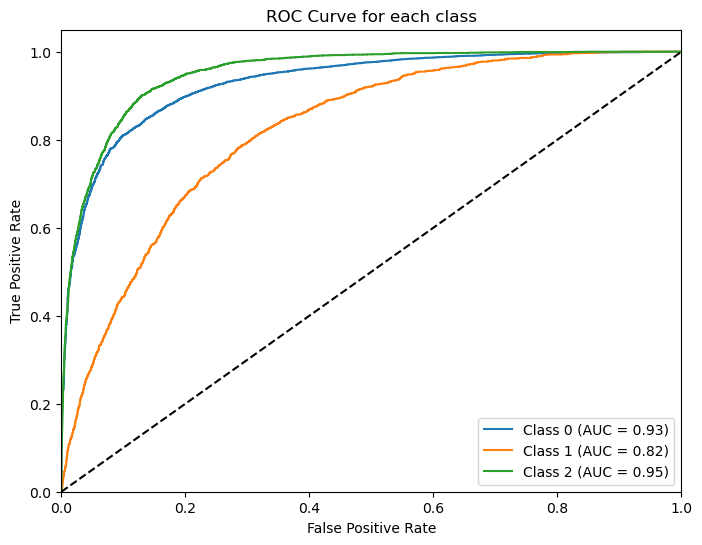

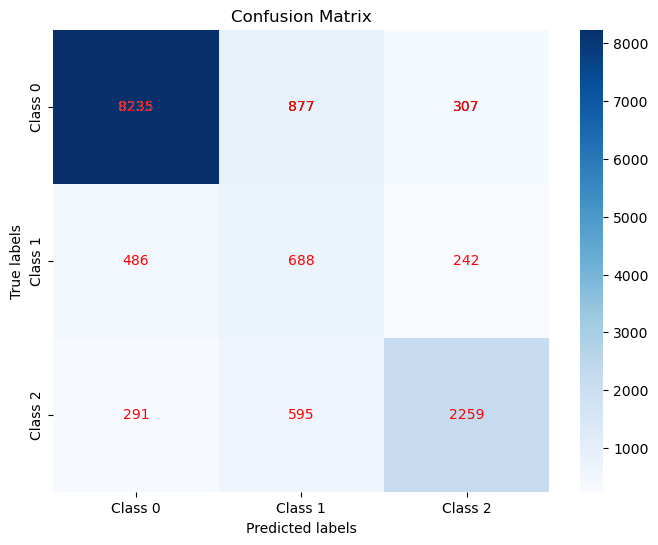

-------------------------------------------
Finished Evaluation


In [41]:
# MAX_LENGTH = 512 and BATCH_SIZE = 8 LR = 2e-05
evaluate('/scratch/user/sathvikkote/models/parameterTuning/pytorch/baseBertWith2LayerClassfier_512_8_2e-05_4.pth', '2', 'PT256_16', [])

Started Evaluating
Path: /scratch/user/sathvikkote/models/LearningParameterTuning/pytorch/baseBertWith2LayerClassfier_256_8_0.0002_5.pth Name: PT256_8_0.0002 Classifier : 2 layer : []
-------------------------------------------


Accuracy=75.9084 f1: 0.7845: 100%|██████████████████████████████████████████████████████| 219/219 [01:36<00:00,  2.27batch/s]


Validation Loss: 0.0127, Validation Loss: 177.8888, Validation Accuracy: 75.9084, val correct: 10612, Val Total: 13980
The F1 score : Weighted 0.7845 Macro 0.6655
Per-class accuracy:
Class 2: 82.10% (2582/3145)
Class 0: 76.64% (7219/9419)
Class 1: 57.27% (811/1416)
The AUC Score : Weighted {0: 0.9381833367593839, 1: 0.8057069836336263, 2: 0.9476115867217688} Macro {0: 0.9381833367593839, 1: 0.8057069836336263, 2: 0.9476115867217688}


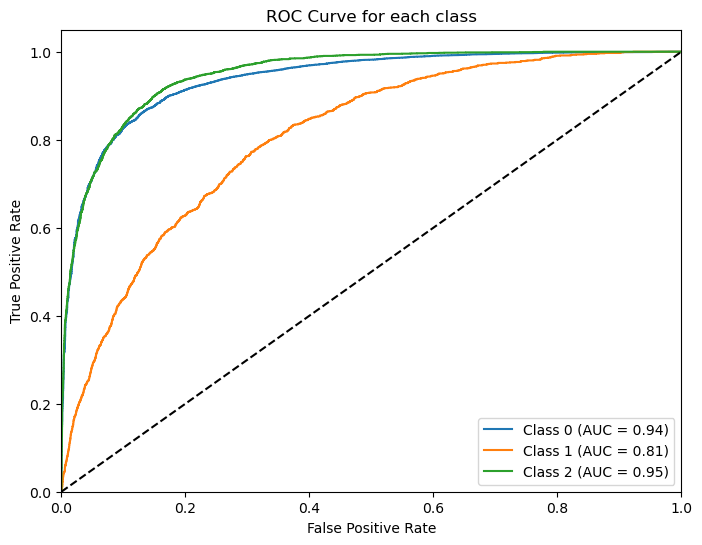

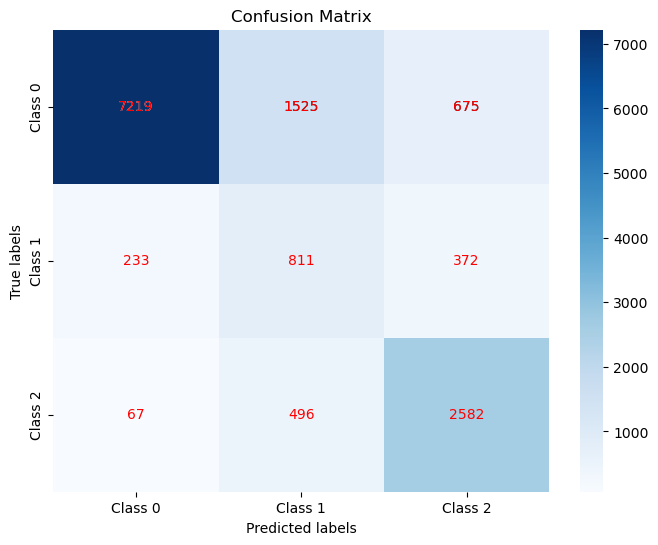

-------------------------------------------
Finished Evaluation


In [42]:
# MAX_LENGTH = 256 and BATCH_SIZE = 8 LR = 2e-04
evaluate('/scratch/user/sathvikkote/models/LearningParameterTuning/pytorch/baseBertWith2LayerClassfier_256_8_0.0002_5.pth', '2', 'PT256_8_0.0002', [])

### 3. Layer Selection

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_1_layer_2e-05_3.pth Name: layer1 Classifier : 2 layer : ['1']
-------------------------------------------


Accuracy=47.4034 f1: 0.5340: 100%|██████████████████████████████████████████████████████| 219/219 [01:35<00:00,  2.29batch/s]


Validation Loss: 0.0171, Validation Loss: 239.5744, Validation Accuracy: 47.4034, val correct: 6627, Val Total: 13980
The F1 score : Weighted 0.5340 Macro 0.4542
Per-class accuracy:
Class 0: 42.37% (3991/9419)
Class 2: 52.34% (1646/3145)
Class 1: 69.92% (990/1416)
The AUC Score : Weighted {0: 0.7895481940562512, 1: 0.6742142940011547, 2: 0.8082321394115961} Macro {0: 0.7895481940562512, 1: 0.6742142940011547, 2: 0.8082321394115961}


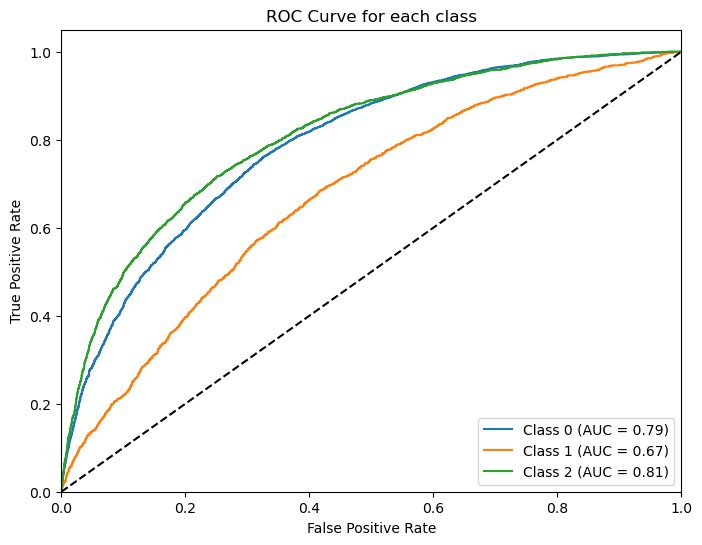

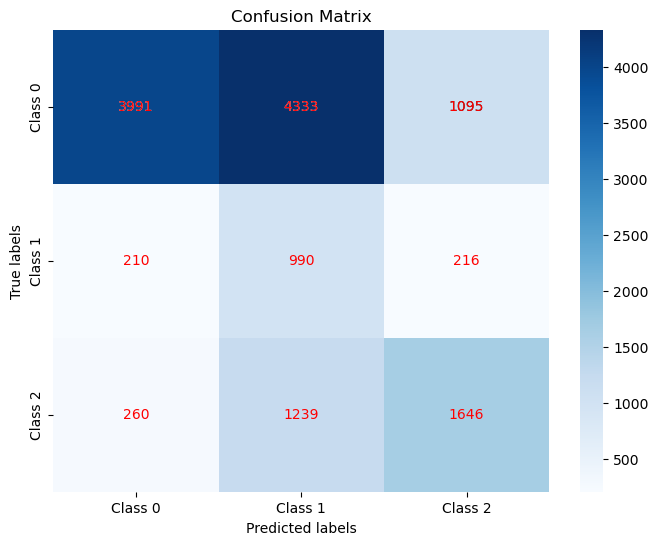

-------------------------------------------
Finished Evaluation


In [43]:
# LAYER 1
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_1_layer_2e-05_3.pth', '2', 'layer1', ['1'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_2_layer_2e-05_3.pth Name: layer2 Classifier : 2 layer : ['2']
-------------------------------------------


Accuracy=66.9957 f1: 0.7049: 100%|██████████████████████████████████████████████████████| 219/219 [01:40<00:00,  2.17batch/s]


Validation Loss: 0.0142, Validation Loss: 198.9500, Validation Accuracy: 66.9957, val correct: 9366, Val Total: 13980
The F1 score : Weighted 0.7049 Macro 0.5867
Per-class accuracy:
Class 1: 54.73% (775/1416)
Class 0: 67.05% (6315/9419)
Class 2: 72.37% (2276/3145)
The AUC Score : Weighted {0: 0.8794643880726515, 1: 0.7494267767111485, 2: 0.8893174610045318} Macro {0: 0.8794643880726515, 1: 0.7494267767111485, 2: 0.8893174610045318}


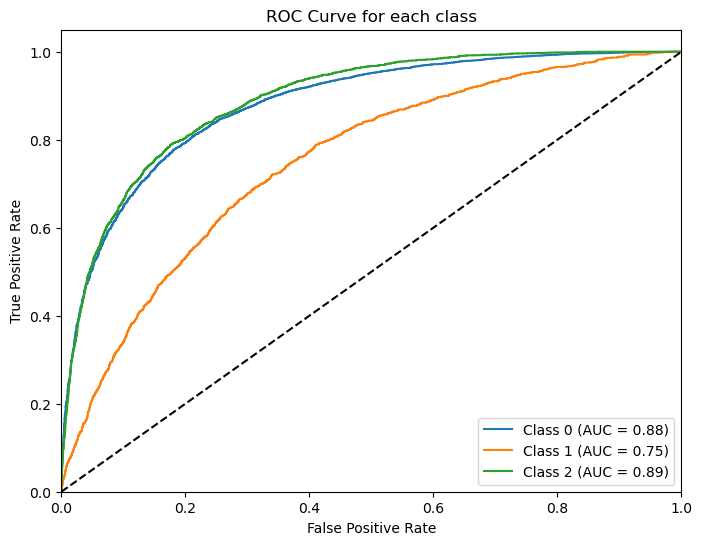

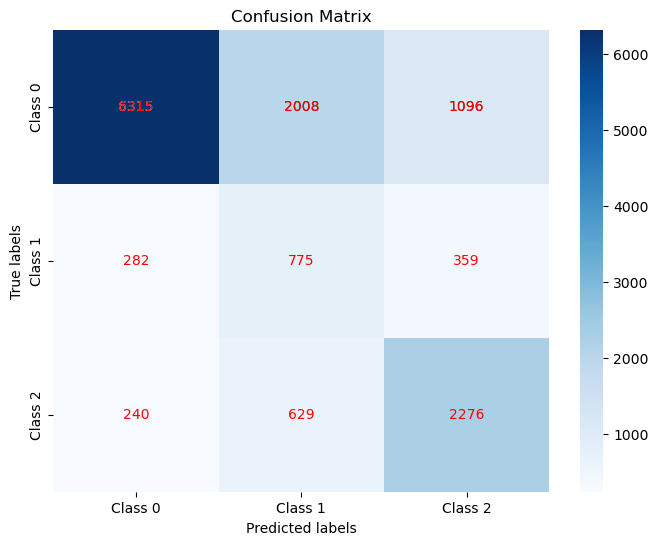

-------------------------------------------
Finished Evaluation


In [44]:
# LAYER 2
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_2_layer_2e-05_3.pth', '2', 'layer2', ['2'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_3_layer_2e-05_3.pth Name: layer3 Classifier : 2 layer : ['3']
-------------------------------------------


Accuracy=65.9800 f1: 0.6853: 100%|██████████████████████████████████████████████████████| 219/219 [01:38<00:00,  2.22batch/s]


Validation Loss: 0.0145, Validation Loss: 202.2893, Validation Accuracy: 65.9800, val correct: 9224, Val Total: 13980
The F1 score : Weighted 0.6853 Macro 0.5608
Per-class accuracy:
Class 1: 39.69% (562/1416)
Class 0: 65.20% (6141/9419)
Class 2: 80.16% (2521/3145)
The AUC Score : Weighted {0: 0.8737103224183189, 1: 0.7351227253186847, 2: 0.8770772308723935} Macro {0: 0.8737103224183189, 1: 0.7351227253186847, 2: 0.8770772308723935}


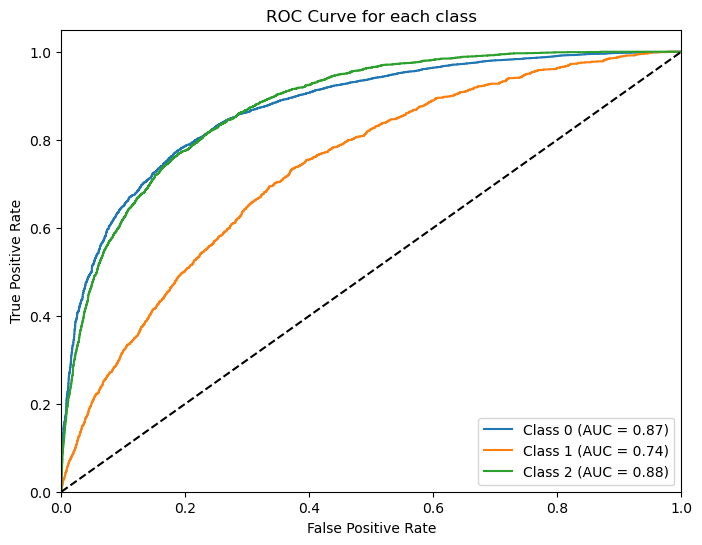

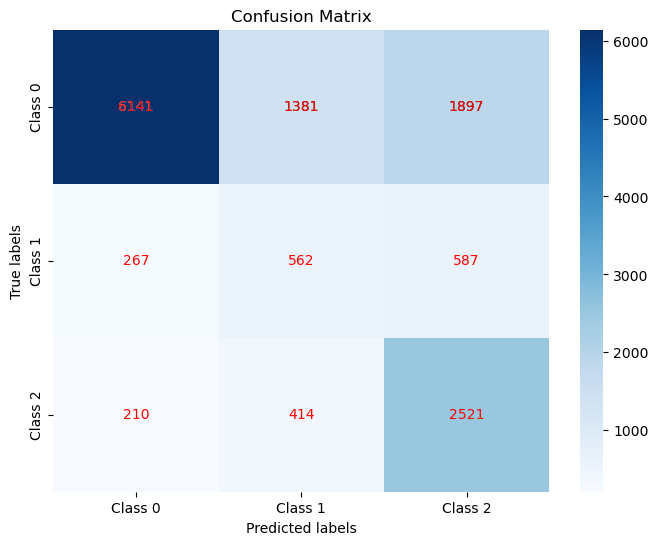

-------------------------------------------
Finished Evaluation


In [45]:
# LAYER 3
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_3_layer_2e-05_3.pth', '2', 'layer3', ['3'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_4_layer_2e-05_3.pth Name: layer4 Classifier : 2 layer : ['4']
-------------------------------------------


Accuracy=58.1259 f1: 0.6289: 100%|██████████████████████████████████████████████████████| 219/219 [01:38<00:00,  2.22batch/s]


Validation Loss: 0.0154, Validation Loss: 215.7324, Validation Accuracy: 58.1259, val correct: 8126, Val Total: 13980
The F1 score : Weighted 0.6289 Macro 0.5394
Per-class accuracy:
Class 0: 51.65% (4865/9419)
Class 2: 73.86% (2323/3145)
Class 1: 66.24% (938/1416)
The AUC Score : Weighted {0: 0.8895394673457037, 1: 0.7410836179776493, 2: 0.8864665751557361} Macro {0: 0.8895394673457037, 1: 0.7410836179776493, 2: 0.8864665751557361}


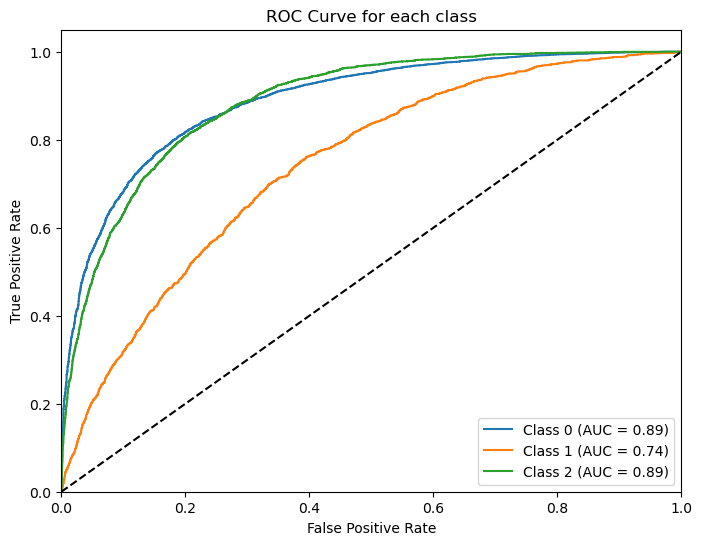

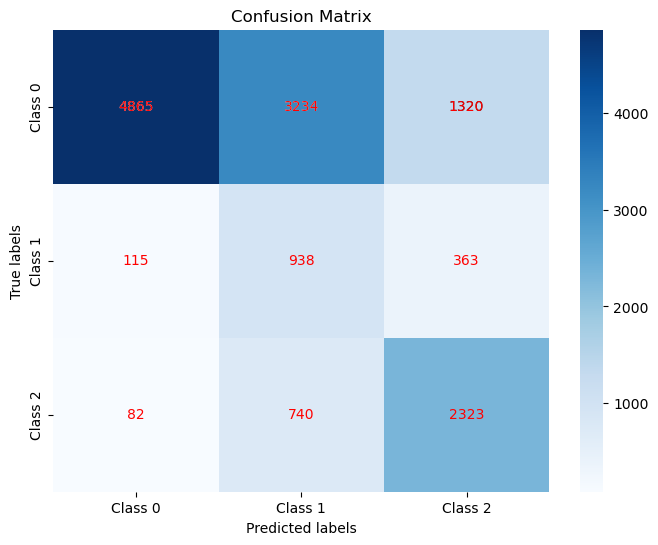

-------------------------------------------
Finished Evaluation


In [46]:
# LAYER 4
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_4_layer_2e-05_3.pth', '2', 'layer4', ['4'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_5_layer_2e-05_3.pth Name: layer5 Classifier : 2 layer : ['5']
-------------------------------------------


Accuracy=66.4378 f1: 0.7025: 100%|██████████████████████████████████████████████████████| 219/219 [01:39<00:00,  2.21batch/s]


Validation Loss: 0.0142, Validation Loss: 198.3008, Validation Accuracy: 66.4378, val correct: 9288, Val Total: 13980
The F1 score : Weighted 0.7025 Macro 0.5880
Per-class accuracy:
Class 2: 72.50% (2280/3145)
Class 0: 65.46% (6166/9419)
Class 1: 59.46% (842/1416)
The AUC Score : Weighted {0: 0.8871786465656389, 1: 0.7668238618274434, 2: 0.8944812159264235} Macro {0: 0.8871786465656389, 1: 0.7668238618274434, 2: 0.8944812159264235}


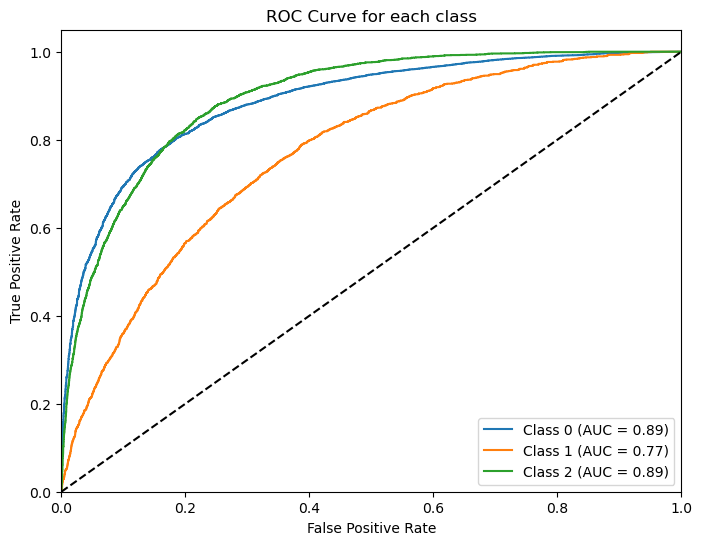

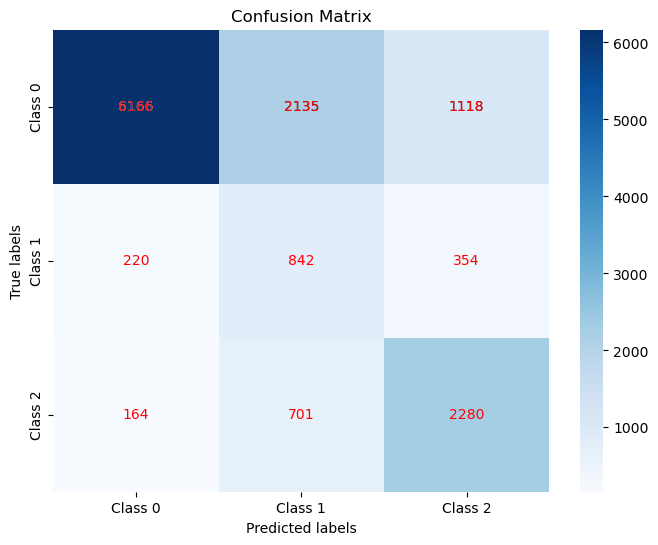

-------------------------------------------
Finished Evaluation


In [47]:
# LAYER 5
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_5_layer_2e-05_3.pth', '2', 'layer5', ['5'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_6_layer_2e-05_3.pth Name: layer6 Classifier : 2 layer : ['6']
-------------------------------------------


Accuracy=72.7682 f1: 0.7559: 100%|██████████████████████████████████████████████████████| 219/219 [01:38<00:00,  2.22batch/s]


Validation Loss: 0.0133, Validation Loss: 185.3210, Validation Accuracy: 72.7682, val correct: 10173, Val Total: 13980
The F1 score : Weighted 0.7559 Macro 0.6371
Per-class accuracy:
Class 0: 74.52% (7019/9419)
Class 2: 73.45% (2310/3145)
Class 1: 59.60% (844/1416)
The AUC Score : Weighted {0: 0.908325195735881, 1: 0.8057509674759019, 2: 0.9165573499882249} Macro {0: 0.908325195735881, 1: 0.8057509674759019, 2: 0.9165573499882249}


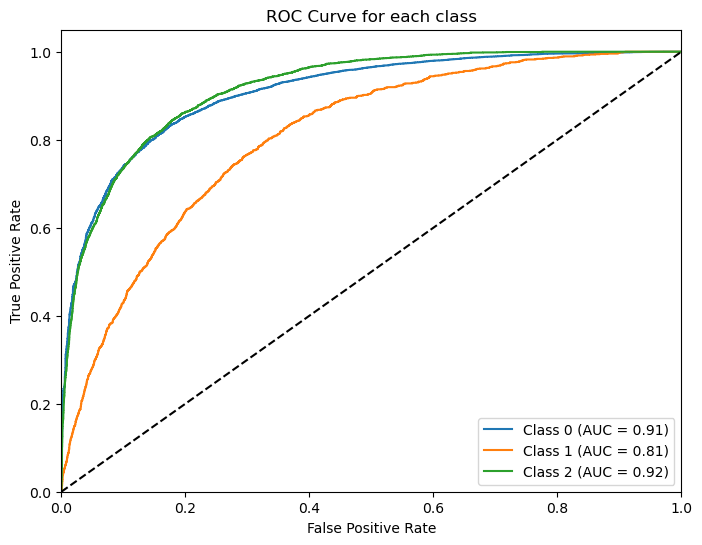

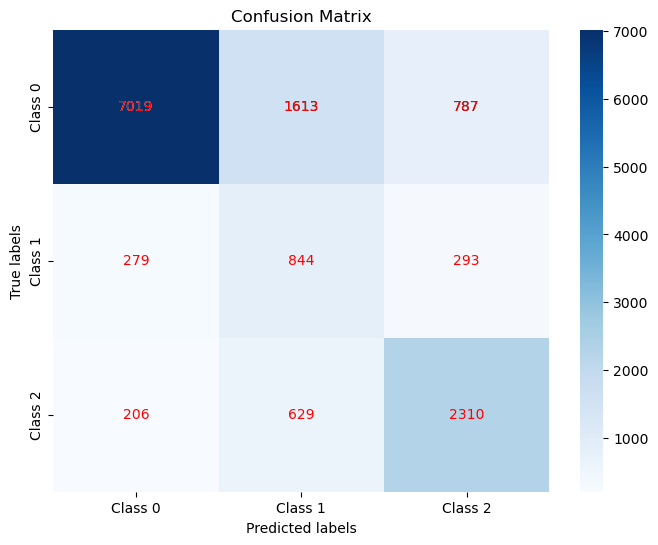

-------------------------------------------
Finished Evaluation


In [48]:
# LAYER 6
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_6_layer_2e-05_3.pth', '2', 'layer6', ['6'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_7_layer_2e-05_3.pth Name: layer7 Classifier : 2 layer : ['7']
-------------------------------------------


Accuracy=74.7997 f1: 0.7742: 100%|██████████████████████████████████████████████████████| 219/219 [01:37<00:00,  2.24batch/s]


Validation Loss: 0.0129, Validation Loss: 179.7049, Validation Accuracy: 74.7997, val correct: 10457, Val Total: 13980
The F1 score : Weighted 0.7742 Macro 0.6486
Per-class accuracy:
Class 0: 79.81% (7517/9419)
Class 2: 66.04% (2077/3145)
Class 1: 60.95% (863/1416)
The AUC Score : Weighted {0: 0.9102928373538779, 1: 0.8131235587914173, 2: 0.9243968972365508} Macro {0: 0.9102928373538779, 1: 0.8131235587914173, 2: 0.9243968972365508}


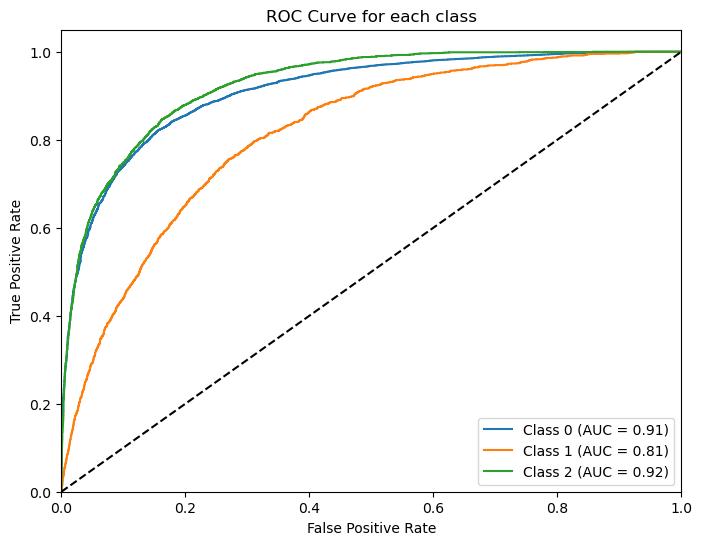

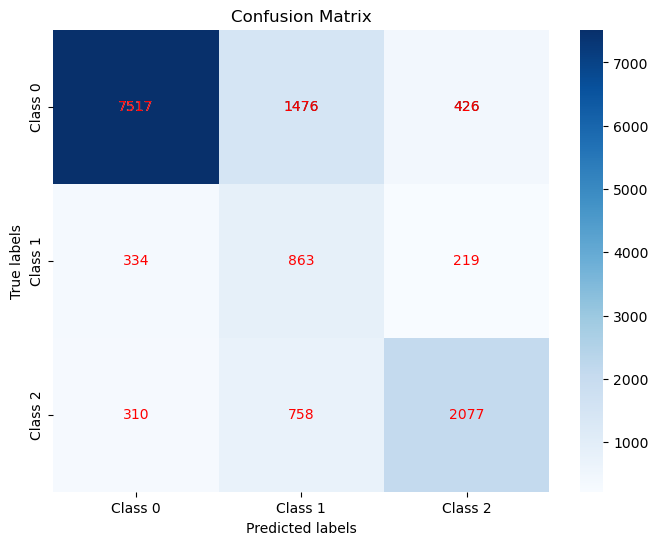

-------------------------------------------
Finished Evaluation


In [49]:
# LAYER 7
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_7_layer_2e-05_3.pth', '2', 'layer7', ['7'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_8_layer_2e-05_3.pth Name: layer8 Classifier : 2 layer : ['8']
-------------------------------------------


Accuracy=71.5665 f1: 0.7538: 100%|██████████████████████████████████████████████████████| 219/219 [01:37<00:00,  2.24batch/s]


Validation Loss: 0.0134, Validation Loss: 186.6388, Validation Accuracy: 71.5665, val correct: 10005, Val Total: 13980
The F1 score : Weighted 0.7538 Macro 0.6355
Per-class accuracy:
Class 0: 73.36% (6910/9419)
Class 2: 68.46% (2153/3145)
Class 1: 66.53% (942/1416)
The AUC Score : Weighted {0: 0.9130000147346166, 1: 0.8050677424243242, 2: 0.927778096509061} Macro {0: 0.9130000147346166, 1: 0.8050677424243242, 2: 0.927778096509061}


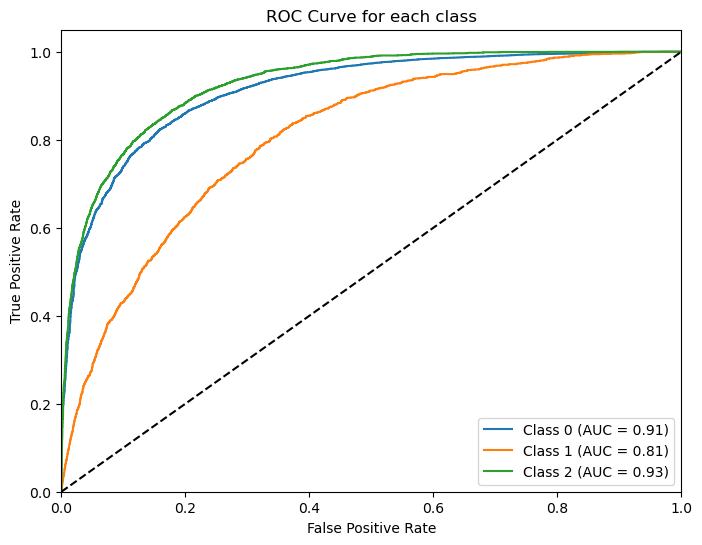

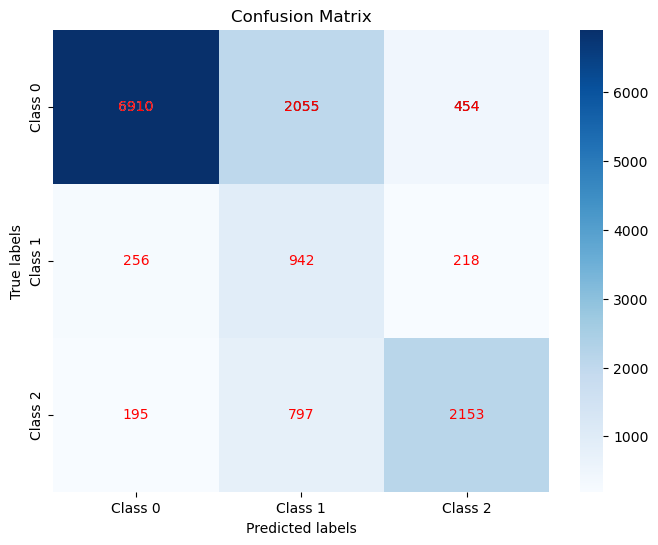

-------------------------------------------
Finished Evaluation


In [50]:
# LAYER 8
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_8_layer_2e-05_3.pth', '2', 'layer8', ['8'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_9_layer_2e-05_3.pth Name: layer9 Classifier : 2 layer : ['9']
-------------------------------------------


Accuracy=75.3147 f1: 0.7790: 100%|██████████████████████████████████████████████████████| 219/219 [01:37<00:00,  2.24batch/s]


Validation Loss: 0.0128, Validation Loss: 178.3874, Validation Accuracy: 75.3147, val correct: 10529, Val Total: 13980
The F1 score : Weighted 0.7790 Macro 0.6624
Per-class accuracy:
Class 0: 75.51% (7112/9419)
Class 1: 57.20% (810/1416)
Class 2: 82.89% (2607/3145)
The AUC Score : Weighted {0: 0.9340346110790956, 1: 0.8056584187266281, 2: 0.9463057731854387} Macro {0: 0.9340346110790956, 1: 0.8056584187266281, 2: 0.9463057731854387}


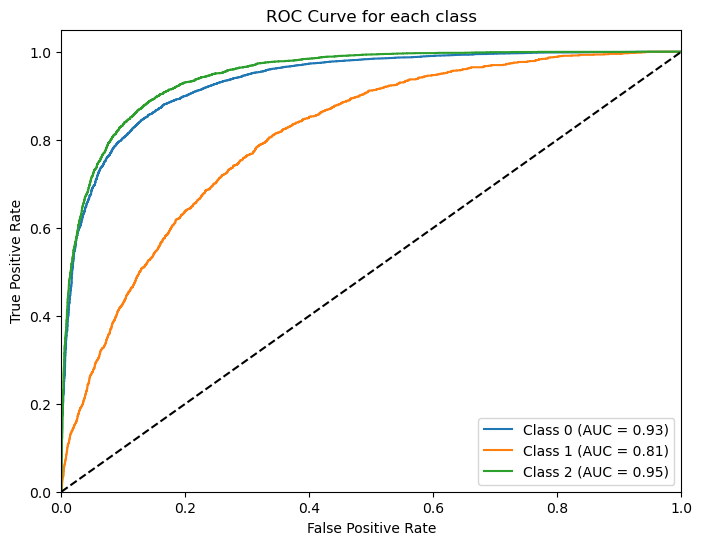

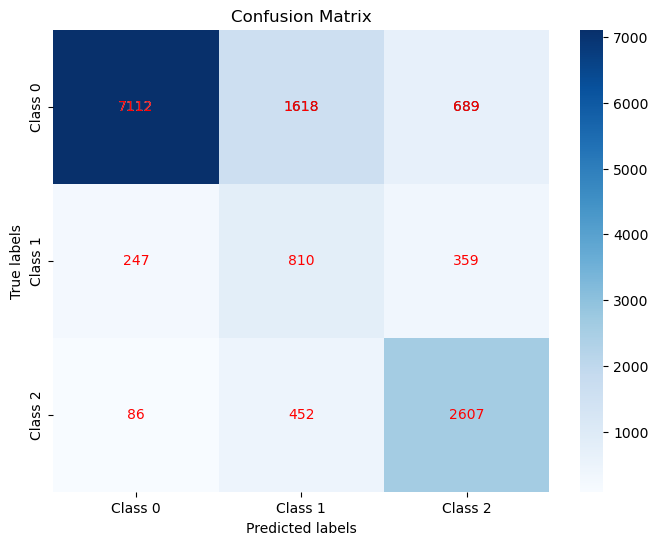

-------------------------------------------
Finished Evaluation


In [51]:
# LAYER 9
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_9_layer_2e-05_3.pth', '2', 'layer9', ['9'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_10_layer_2e-05_3.pth Name: layer10 Classifier : 2 layer : ['10']
-------------------------------------------


Accuracy=79.7353 f1: 0.8144: 100%|██████████████████████████████████████████████████████| 219/219 [01:40<00:00,  2.18batch/s]


Validation Loss: 0.0120, Validation Loss: 168.4295, Validation Accuracy: 79.7353, val correct: 11147, Val Total: 13980
The F1 score : Weighted 0.8144 Macro 0.6937
Per-class accuracy:
Class 2: 82.45% (2593/3145)
Class 0: 82.69% (7789/9419)
Class 1: 54.03% (765/1416)
The AUC Score : Weighted {0: 0.9428073294778295, 1: 0.8245347099685765, 2: 0.9574067876068473} Macro {0: 0.9428073294778295, 1: 0.8245347099685765, 2: 0.9574067876068473}


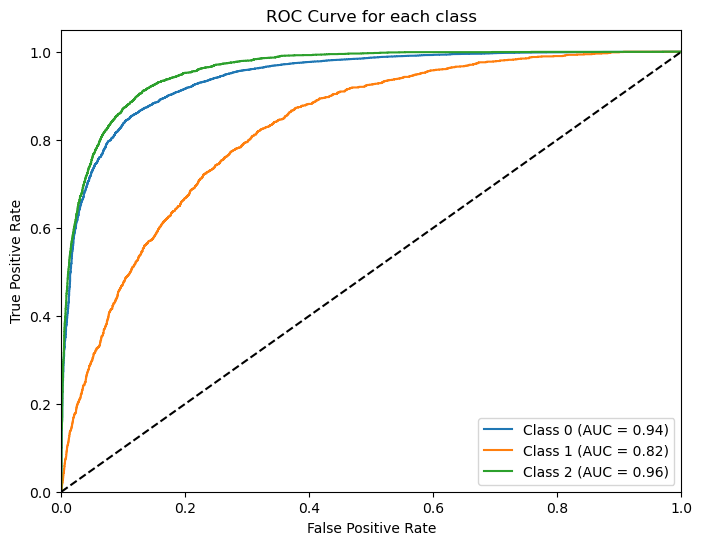

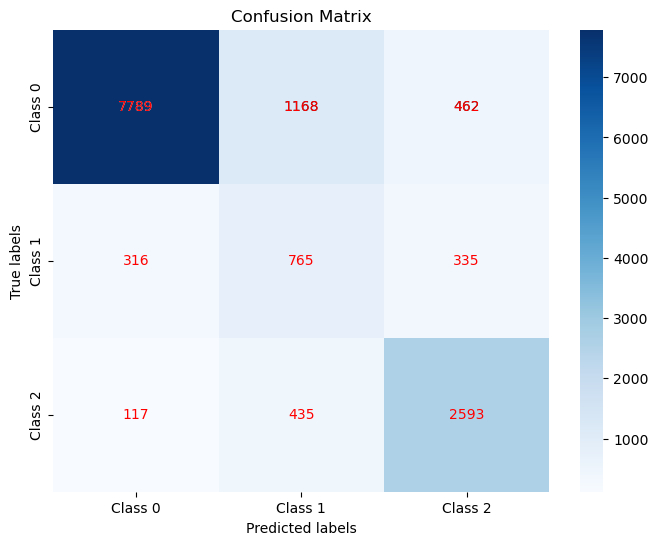

-------------------------------------------
Finished Evaluation


In [52]:
# LAYER 10
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_10_layer_2e-05_3.pth', '2', 'layer10', ['10'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_11_layer_2e-05_3.pth Name: layer11 Classifier : 2 layer : ['11']
-------------------------------------------


Accuracy=79.9857 f1: 0.8167: 100%|██████████████████████████████████████████████████████| 219/219 [01:36<00:00,  2.28batch/s]


Validation Loss: 0.0120, Validation Loss: 167.4958, Validation Accuracy: 79.9857, val correct: 11182, Val Total: 13980
The F1 score : Weighted 0.8167 Macro 0.6951
Per-class accuracy:
Class 2: 81.62% (2567/3145)
Class 0: 83.31% (7847/9419)
Class 1: 54.24% (768/1416)
The AUC Score : Weighted {0: 0.9439851211563745, 1: 0.8292413745577446, 2: 0.9580789600915011} Macro {0: 0.9439851211563745, 1: 0.8292413745577446, 2: 0.9580789600915011}


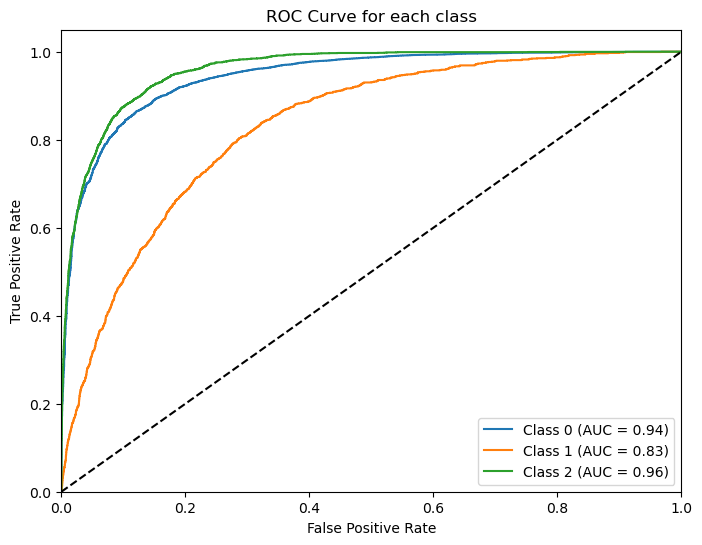

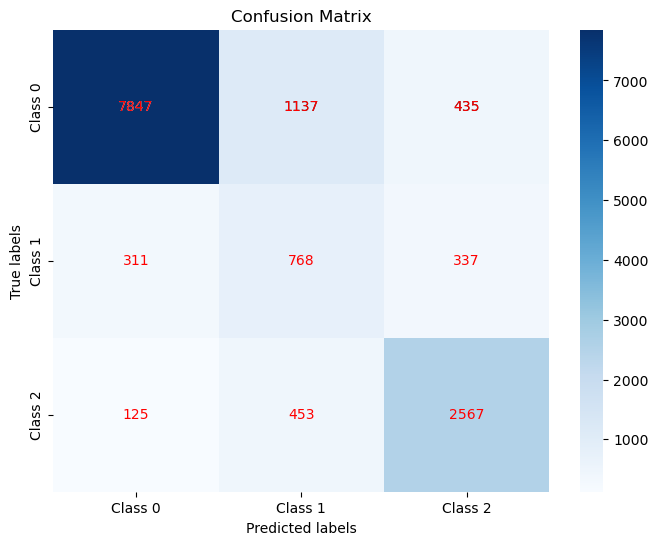

-------------------------------------------
Finished Evaluation


In [53]:
# LAYER 11
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_11_layer_2e-05_3.pth', '2', 'layer11', ['11'])

Started Evaluating
Path: /scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_12_layer_2e-05_3.pth Name: layer12 Classifier : 2 layer : ['12']
-------------------------------------------


Accuracy=80.5651 f1: 0.8250: 100%|██████████████████████████████████████████████████████| 219/219 [01:36<00:00,  2.27batch/s]


Validation Loss: 0.0119, Validation Loss: 165.7530, Validation Accuracy: 80.5651, val correct: 11263, Val Total: 13980
The F1 score : Weighted 0.8250 Macro 0.7061
Per-class accuracy:
Class 0: 84.24% (7935/9419)
Class 2: 78.98% (2484/3145)
Class 1: 59.60% (844/1416)
The AUC Score : Weighted {0: 0.9492588220141877, 1: 0.8404095606764551, 2: 0.9634172803059038} Macro {0: 0.9492588220141877, 1: 0.8404095606764551, 2: 0.9634172803059038}


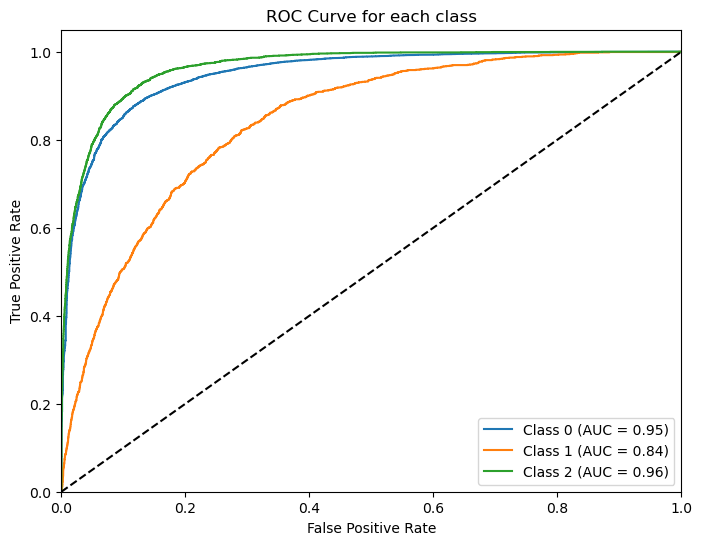

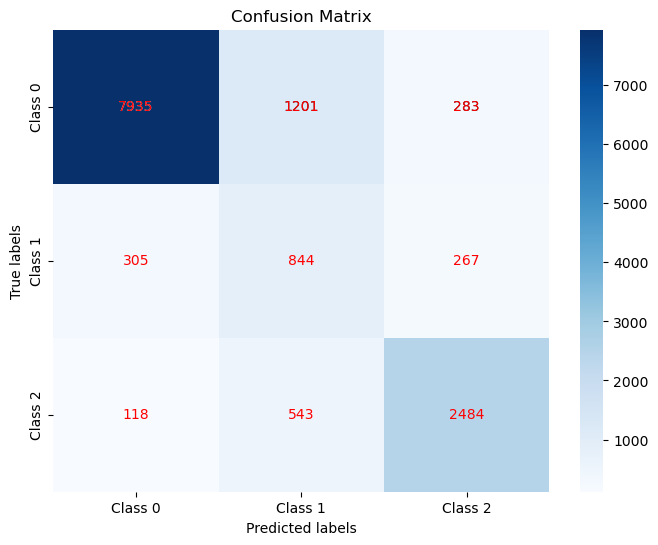

-------------------------------------------
Finished Evaluation


In [54]:
# LAYER 12
evaluate('/scratch/user/sathvikkote/models/pytorch/bert_with_2_fnn_12_layer_2e-05_3.pth', '2', 'layer12', ['12'])

#### 4.Unfreezing the bert model

Started Evaluating
Path: /scratch/user/sathvikkote/models/train/bert_with_2_fnn_unfreeze_12_layer_2e-05_3.pth Name: Unfreeze Classifier : 2 layer : ['12']
-------------------------------------------


Accuracy=85.5508 f1: 0.8707: 100%|██████████████████████████████████████████████████████| 219/219 [01:36<00:00,  2.27batch/s]


Validation Loss: 0.0109, Validation Loss: 153.0574, Validation Accuracy: 85.5508, val correct: 11960, Val Total: 13980
The F1 score : Weighted 0.8707 Macro 0.7736
Per-class accuracy:
Class 0: 87.48% (8240/9419)
Class 1: 73.31% (1038/1416)
Class 2: 85.28% (2682/3145)
The AUC Score : Weighted {0: 0.9714385634340028, 1: 0.8861205767712251, 2: 0.979341708221971} Macro {0: 0.9714385634340028, 1: 0.8861205767712251, 2: 0.979341708221971}


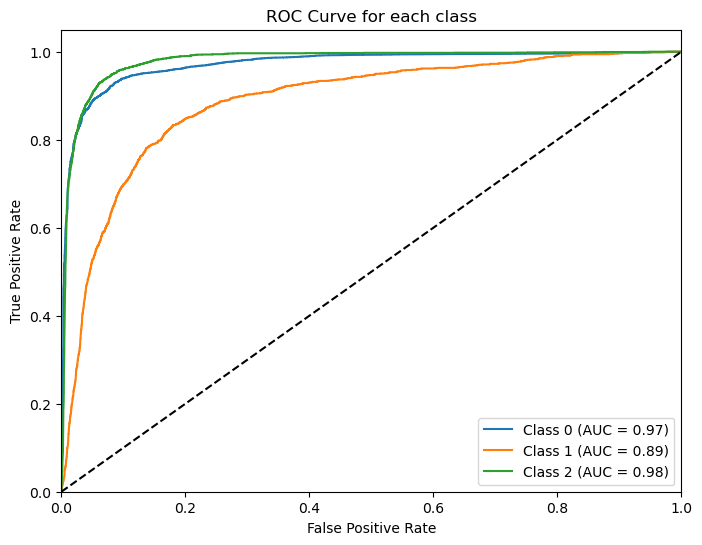

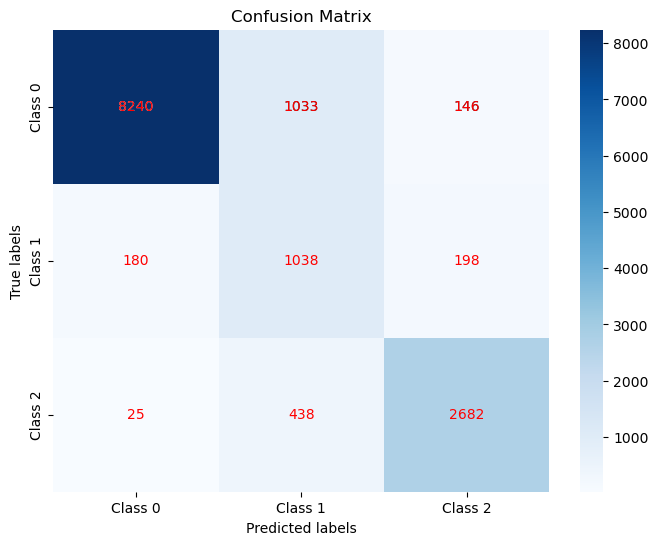

-------------------------------------------
Finished Evaluation


In [55]:
evaluate('/scratch/user/sathvikkote/models/train/bert_with_2_fnn_unfreeze_12_layer_2e-05_3.pth', '2', 'Unfreeze', ['12'])

# Conclusion

Below is the final model which uses the [CLS] token from 12th hidden layer of base-bert model and adds two layer classifier to its end.

In [56]:
pretrained_bert = BertModel.from_pretrained('bert-base-uncased',  output_hidden_states=True)
name = 'BertBasedTextClassifier'
BertBasedTextClassifier = BaseBertLayerwiseClassifier(pretrained_bert,  FNN2LayerClassifier(3), 12)
BertBasedTextClassifier.load_state_dict(torch.load('/scratch/user/sathvikkote/models/train/bert_with_2_fnn_unfreeze_12_layer_2e-05_3.pth'))

print(BertBasedTextClassifier)

BaseBertLayerwiseClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e